# Big Data - TP #2

El objetivo de este TP es hacer una limpieza y análisis de la EPH. Asimismo, predecir si una persona es o no pobre
utilizando datos distintos al ingreso usando las metodologías vistas en clase.

In [29]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Parte I: Analizando la base

In [3]:
# Abrimos el archivo y vemos las primeras cinco filas
eph_indiv = pd.read_excel("../datasets/usu_individual_T123.xlsx")
eph_indiv.head(5)

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH
0,TQRMNORVWHLMKOCDEOHCH00720228,2023,1,1,5,0,44,N,91,112,...,10.0,9,79700.0,6,6.0,5,NaN,7.0,5,133
1,TQRMNOPSTHKMKPCDEOHCH00781447,2023,1,1,1,1,44,N,91,190,...,6.0,5,180000.0,9,10.0,9,NaN,10.0,9,200
2,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,1,1,44,N,91,134,...,8.0,8,145000.0,9,9.0,8,NaN,9.0,8,140
3,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,2,1,44,N,91,134,...,8.0,8,145000.0,9,9.0,8,NaN,9.0,8,140
4,TQRMNOQYTHMNKSCDEOHCH00803178,2023,1,1,1,1,44,N,91,120,...,12.0,12,0.0,12,12.0,12,NaN,12.0,12,0


In [4]:
#Resumen de la base de datos
eph_indiv.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48638 entries, 0 to 48637
Data columns (total 177 columns):
 #    Column      Dtype  
---   ------      -----  
 0    CODUSU      object 
 1    ANO4        int64  
 2    TRIMESTRE   int64  
 3    NRO_HOGAR   int64  
 4    COMPONENTE  int64  
 5    H15         int64  
 6    REGION      int64  
 7    MAS_500     object 
 8    AGLOMERADO  int64  
 9    PONDERA     int64  
 10   CH03        int64  
 11   CH04        int64  
 12   CH05        object 
 13   CH06        int64  
 14   CH07        int64  
 15   CH08        float64
 16   CH09        int64  
 17   CH10        int64  
 18   CH11        int64  
 19   CH12        int64  
 20   CH13        int64  
 21   CH14        float64
 22   CH15        int64  
 23   CH15_COD    float64
 24   CH16        int64  
 25   CH16_COD    float64
 26   NIVEL_ED    int64  
 27   ESTADO      int64  
 28   CAT_OCUP    int64  
 29   CAT_INAC    int64  
 30   IMPUTA      float64
 31   PP02C1      int64  
 32   

In [ ]:
#2a) Eliminen todas las observaciones que no corresponden a los aglomerados de CABA o Gran Buenos Aires

In [ ]:
#2b) Si hay observaciones con valores que no tienen sentido, descartarlas

Mujer    52.06423
Varón    47.93577
Name: gender, dtype: float64


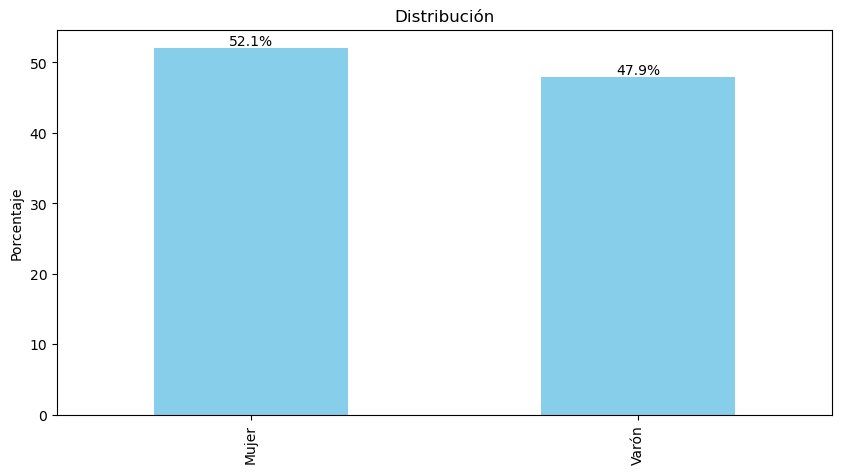

In [24]:
#2c) Gráfico de barras mostrando la composición por sexo
eph_indiv['gender'] = eph_indiv['CH04'].map({1: 'Varón', 2: 'Mujer'})
gender_counts = eph_indiv['gender'].value_counts(normalize=True) * 100
print(gender_counts) # Para conocer los porcentajes

# Gráfico de barras
barplot = plt.figure(figsize = (10, 5))
ax = gender_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución')
plt.ylabel('Porcentaje')

# Add percentage labels on top of the bars
for i, v in enumerate(gender_counts):
    ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.show()

               CH04          CH07          CH08      NIVEL_ED        ESTADO  \
count  48638.000000  48638.000000  48637.000000  48638.000000  48638.000000   
mean       1.520642      3.516674      2.179370      3.728196      2.214400   
std        0.499579      1.654503      1.832863      1.774883      1.148871   
min        1.000000      1.000000      1.000000      1.000000      0.000000   
25%        1.000000      2.000000      1.000000      2.000000      1.000000   
50%        2.000000      5.000000      1.000000      4.000000      3.000000   
75%        2.000000      5.000000      4.000000      5.000000      3.000000   
max        2.000000      9.000000     23.000000      7.000000      4.000000   

           CAT_INAC          IPCF  
count  48638.000000  4.863800e+04  
mean       1.546527  5.378648e+04  
std        1.827469  6.849848e+04  
min        0.000000  0.000000e+00  
25%        0.000000  9.600000e+03  
50%        1.000000  4.000000e+04  
75%        3.000000  7.333333e+04  


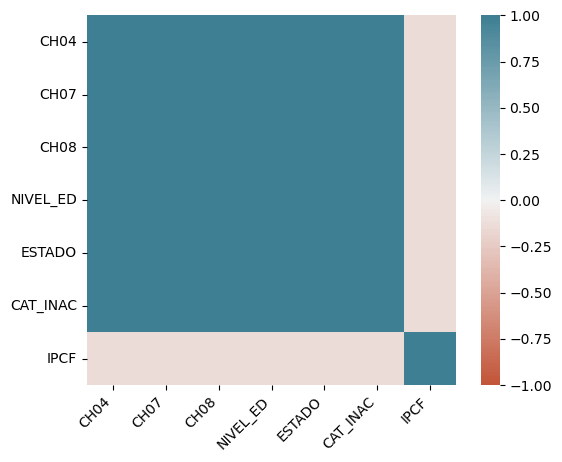

In [30]:
#2d) Matriz de correlación con las siguientes variables
covars = eph_indiv[['CH04', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'IPCF']].describe()
print(covars) #Breve descripción de las variables

cmap = sns.diverging_palette(20, 220, n=200)

# Heatmap
ax = sns.heatmap(
    covars.corr(),  # Use .corr() to get the correlation matrix
    vmin=-1, vmax=1,
    center=0,
    cmap=cmap,
    square=True
)

# Customize
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

In [ ]:
#2e) Calcular a los desocupados, inactivos y la media del ingreso pc segun estado (ocupado, desocupado, inactivo)

## Parte II: Clasificación